# TTC Delay Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import os
import seaborn as sns
from datetime import datetime as dt

c:\Users\yuqih\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


1. import data

In [2]:
# Find all ttc subway ridership data file from the path
filenames = [file for file in os.listdir("TTC_delay") if ('ttc-subway-delay' in file) and (not 'readme' in file) and (not 'codes' in file)]
filenames

['ttc-subway-delay-data-2018.xlsx',
 'ttc-subway-delay-data-2019.xlsx',
 'ttc-subway-delay-data-2020.xlsx',
 'ttc-subway-delay-data-2021.xlsx',
 'ttc-subway-delay-data-2022.xlsx',
 'ttc-subway-delay-data-2023.xlsx',
 'ttc-subway-delay-jan-2014-april-2017.xlsx',
 'ttc-subway-delay-may-december-2017.xlsx']

In [3]:
def combine_excel_sheets(filenames, folder_path):
    all_dataframes = []

    # Read through all sheets of Excel file and combine as a dataframe
    for file in filenames:
        try:
            # Read the Excel file
            xls = pd.ExcelFile(os.path.join(folder_path, file))
            # Get all sheets names
            sheet_names = xls.sheet_names

            # Combine all dataframes
            combined_df = pd.concat([xls.parse(sheet_name) for sheet_name in sheet_names], ignore_index = True)

            # Append the combined dataframe to the list
            all_dataframes.append(combined_df)

        # If there are any errors to read the file
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    # Make all_dataframes as a dataframe
    result_df = pd.concat(all_dataframes, ignore_index = True)
    
    return result_df



In [4]:
# Import TTC delay codes
delayed_data = combine_excel_sheets(filenames, r"TTC_delay")
delayed_data.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781


In [5]:
delayed_data.shape

(188121, 10)

In [6]:
delayed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188121 entries, 0 to 188120
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       188121 non-null  datetime64[ns]
 1   Time       188121 non-null  object        
 2   Day        188121 non-null  object        
 3   Station    188121 non-null  object        
 4   Code       188120 non-null  object        
 5   Min Delay  188121 non-null  int64         
 6   Min Gap    188121 non-null  int64         
 7   Bound      142443 non-null  object        
 8   Line       187478 non-null  object        
 9   Vehicle    188121 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 14.4+ MB


import delay codes

In [7]:
# Import TTC delay codes
codes = pd.read_excel(os.path.join('TTC_delay', 'ttc-subway-delay-codes.xlsx'), header = 1)
codes.head()

,Unnamed: 0,Unnamed: 1,SUB RMENU CODE,CODE DESCRIPTION,Unnamed: 4,Unnamed: 5,SRT RMENU CODE,CODE DESCRIPTION.1
0,NaN,1,EUAC,Air Conditioning,NaN,1.0,ERAC,Air Conditioning
1,NaN,2,EUAL,Alternating Current,NaN,2.0,ERBO,Body
2,NaN,3,EUATC,ATC RC&S Equipment,NaN,3.0,ERCD,Consequential Delay (2nd Delay Same Fault)
3,NaN,4,EUBK,Brakes,NaN,4.0,ERCO,Couplers
4,NaN,5,EUBO,Body,NaN,5.0,ERDB,Disc Brakes


In [8]:
# Since the code abbreviation and code describtion are divided into four different columns, seperate them into two dataframe and concat into one
TTC_delay_code_name_raw_1 = pd.DataFrame({
    "Code": codes.iloc[:,2],
    "Code description": codes.iloc[:,3]
})
TTC_delay_code_name_raw_2 = pd.DataFrame({
    "Code": codes.iloc[:,6],
    "Code description": codes.iloc[:,7]
})

TTC_delay_code_name = pd.concat([TTC_delay_code_name_raw_1, TTC_delay_code_name_raw_2], axis=0)

## Reset the index
TTC_delay_code_name = TTC_delay_code_name.reset_index(drop=True)

## Take a look
TTC_delay_code_name.head()

,Code,Code description
0,EUAC,Air Conditioning
1,EUAL,Alternating Current
2,EUATC,ATC RC&S Equipment
3,EUBK,Brakes
4,EUBO,Body


In [9]:
## Add the column "code duscription" into TTC 2023 delay data 
delayed_data = pd.merge(delayed_data, TTC_delay_code_name, on="Code", how='left')
delayed_data.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other


In [10]:
# Combine date and time data and convert it to datetime type
delayed_data["Datetime"] = pd.to_datetime(delayed_data['Date'].astype(str) + ' ' + delayed_data['Time'])
## Drop the "Time" and "Date" columns
delayed_data = delayed_data.drop(columns='Time')
delayed_data = delayed_data.drop(columns='Date')

delayed_data

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,Datetime
0,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project,2018-01-01 00:29:00
1,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN,2018-01-01 01:07:00
2,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control,2018-01-01 01:22:00
3,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,2018-01-01 01:28:00
4,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other,2018-01-01 01:39:00
...,...,...,...,...,...,...,...,...,...,...
188173,Sunday,KEELE STATION,SUUT,0,0,W,BD,5245,Unauthorized at Track Level,2017-12-31 23:24:00
188174,Sunday,BAY STATION,PUMEL,0,0,NaN,BD,0,Escalator/Elevator Incident,2017-12-31 23:44:00
188175,Sunday,WARDEN STATION,MUSC,0,0,W,BD,5225,Miscellaneous Speed Control,2017-12-31 23:44:00
188176,Sunday,GLENCAIRN STATION,SUUT,10,14,S,YU,5576,Unauthorized at Track Level,2017-12-31 23:58:00


In [11]:
# Set the Datetime as the index
delayed_data = delayed_data.set_index("Datetime")
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description
Datetime,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other


In [12]:
# Create a function to capture the what time interval does each datetime index falls

def get_hour_interval(hour):
    start_hour = f"{hour:02d}:00"
    end_hour = f"{(hour + 1) % 24:02d}:00"  # Use modulo 24 for the hour after 23:00 to wrap around to 00:00
    return f"{start_hour} - {end_hour}"

In [13]:
# Create a new column for time interval
delayed_data['time_interval'] = delayed_data.index.hour.map(get_hour_interval)
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project,00:00 - 01:00
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other,01:00 - 02:00


In [14]:
# Check subway lines
delayed_data["Line"].unique()

array(['YU', 'BD', 'SRT', 'SHP', 'YU/BD', nan, 'YU / BD', 'YU/ BD',
       'YU-BD', 'BLOOR DANFORTH LINES', '999', 'BD/YU', '16 MCCOWAN',
       'YUS', 'YONGE UNIVERSITY SERVI', '704 RAD BUS', 'B/D', 'BD LINE',
       'YU & BD', 'YU\\BD', '46 MARTIN GROVE', 'RT', 'BLOOR-DANFORTH',
       '134 PROGRESS', 'YU - BD', '985 SHEPPARD EAST EXPR', '22 COXWELL',
       '100 FLEMINGDON PARK', 'YU LINE', '29 DUFFERIN', '95 YORK MILLS',
       '35 JANE', 'BLOOR - DANFORTH', 'YU/BD LINE', 'YUS/BD',
       '40 JUNCTION-DUNDAS WES', '71 RUNNYMEDE', '102 MARKHAM ROAD',
       'YUS/DB', 'SHEP', 'YONGE/UNIVERSITY/BLOOR', '36 FINCH WEST',
       'YUS & BD', 'YU & BD LINES', '52', '41 KEELE', 'Y/BD',
       'YU/BD LINES', 'YUS AND BD', '69 WARDEN SOUTH', 'LINE 2 SHUTTLE',
       '57 MIDLAND', '96 WILSON', '506 CARLTON', 'BLOOR DANFORTH & YONGE',
       'BD LINE 2', 'BD/YUS', 'BLOOR DANFORTH', '31 GREENWOOD', '60',
       '9 BELLAMY', '45 KIPLING', '504', '500', 'SHEPPARD', '104 FAYWOOD',
       '60 STEELE

In [15]:
# Replace subway line to the standard
delayed_data["Line"] = delayed_data["Line"].replace(['YU / BD', 'YU/ BD', 'YU-BD', 'BD/YU', 
                                                     'YU & BD', 'YU\\BD', 'YU/BD LINE', 
                                                     'YUS/BD', 'YUS/DB', 'YUS & BD', 
                                                     'YU & BD LINES', 'Y/BD', 'YU/BD LINES',
                                                     'YUS AND BD', 'BLOOR DANFORTH & YONGE',
                                                     'BD/YUS', 'YU BD', 'YU - BD LINE', 
                                                     'YU - BD', 'YONGE/UNIVERSITY/BLOOR'] ,"YU/BD")
delayed_data["Line"] = delayed_data["Line"].replace(['BLOOR DANFORTH LINES', 'B/D', 'BD LINE', 
                                                     'BLOOR-DANFORTH', 'BLOOR - DANFORTH', 
                                                     'BD LINE 2', 'BLOOR DANFORTH', 'BLOOR DANFORTH LINE',
                                                     ] ,"BD")
delayed_data["Line"] = delayed_data["Line"].replace(['YU', 'YONGE UNIVERSITY SERVI', 'YU LINE', 
                                                     'BLOOR-DANFORTH', 'BLOOR - DANFORTH', 
                                                     'BD LINE 2', 'BLOOR DANFORTH', 'BLOOR DANFORTH LINE',
                                                     ] ,"YUS")
delayed_data["Line"] = delayed_data["Line"].replace(['SHEPPARD'] ,'SHP')

delayed_data["Line"].unique()


array(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', nan, '999', '16 MCCOWAN',
       '704 RAD BUS', '46 MARTIN GROVE', 'RT', '134 PROGRESS',
       '985 SHEPPARD EAST EXPR', '22 COXWELL', '100 FLEMINGDON PARK',
       '29 DUFFERIN', '95 YORK MILLS', '35 JANE',
       '40 JUNCTION-DUNDAS WES', '71 RUNNYMEDE', '102 MARKHAM ROAD',
       'SHEP', '36 FINCH WEST', '52', '41 KEELE', '69 WARDEN SOUTH',
       'LINE 2 SHUTTLE', '57 MIDLAND', '96 WILSON', '506 CARLTON',
       '31 GREENWOOD', '60', '9 BELLAMY', '45 KIPLING', '504', '500',
       '104 FAYWOOD', '60 STEELES WEST', '25 DON MILLS', '555',
       '126 CHRISTIE', '37 ISLINGTON', '504 KING', '116 MORNINGSIDE',
       '73 ROYAL YORK', 'YU/SHEP', '66', '341 KEELE', '510 SPADINA',
       '11 BAYVIEW', '63 OSSINGTON', '32 EGLINTON WEST',
       '129 MCCOWAN NORTH', '85 SHEPPARD EAST'], dtype=object)

In [16]:
# Filter subway lines out
delayed_data = delayed_data[delayed_data["Line"].isin(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', 'RT', 'SHEP', 'LINE 2 SHUTTLE', 'YU/SHEP'])]
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YUS,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YUS,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00


In [17]:
# Double check
delayed_data["Line"].unique()

array(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', 'RT', 'SHEP', 'LINE 2 SHUTTLE',
       'YU/SHEP'], dtype=object)

In [18]:
# See the size of the delayed_data now
delayed_data.shape

(187476, 10)

2. Explore the time data

In [19]:
# Filter out the delays more than 1 minute
real_delay = delayed_data.loc[(delayed_data["Min Delay"] != 0) & (delayed_data["Min Gap"] != 0)]
real_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00
2018-01-01 02:09:00,Monday,KIPLING STATION,MUSAN,3,7,E,BD,5261,Unsanitary Vehicle,02:00 - 03:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00


In [20]:
# See how many real delays are there
real_delay.shape

(63542, 10)

In [21]:
# Check real delay infos
real_delay.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63542 entries, 2018-01-01 00:29:00 to 2017-12-31 23:58:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Day               63542 non-null  object
 1   Station           63542 non-null  object
 2   Code              63542 non-null  object
 3   Min Delay         63542 non-null  int64 
 4   Min Gap           63542 non-null  int64 
 5   Bound             62915 non-null  object
 6   Line              63542 non-null  object
 7   Vehicle           63542 non-null  int64 
 8   Code description  63279 non-null  object
 9   time_interval     63542 non-null  object
dtypes: int64(3), object(7)
memory usage: 5.3+ MB


In [22]:
# See the empty Code description codes --> No description for those
real_delay[real_delay["Code description"].isnull()]

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-11 00:23:00,Thursday,CASTLE FRANK STATION,PUTDN,4,8,E,BD,5112,NaN,00:00 - 01:00
2018-01-15 06:03:00,Monday,ISLINGTON STATION,PUTDN,3,7,E,BD,5313,NaN,06:00 - 07:00
2018-02-17 18:46:00,Saturday,MAIN STREET STATION,PUTDN,10,14,W,BD,5206,NaN,18:00 - 19:00
2018-04-04 18:11:00,Wednesday,WILSON STATION,PUTDN,8,11,S,YUS,6026,NaN,18:00 - 19:00
2018-05-04 17:29:00,Friday,ROSEDALE STATION,PUTDN,11,13,N,YUS,5906,NaN,17:00 - 18:00
...,...,...,...,...,...,...,...,...,...,...
2017-09-02 22:56:00,Saturday,FINCH STATION,PUTDN,12,16,N,YUS,5656,NaN,22:00 - 23:00
2017-10-15 18:05:00,Sunday,EGLINTON STATION,PUTDN,8,12,S,YUS,5101,NaN,18:00 - 19:00
2017-11-21 10:21:00,Tuesday,WARDEN STATION,PUTDN,3,6,W,BD,5082,NaN,10:00 - 11:00


didn't find MUNCA meaning from the code file.

In [23]:
# Calculate the real delay percentage
real_delay_per = real_delay.shape[0] / delayed_data.shape[0]
real_delay_per

0.3389340502250955

In [24]:
# Create the dataframe without delay
no_delay = delayed_data.loc[(delayed_data["Min Delay"] == 0) & (delayed_data["Min Gap"] == 0)]
no_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YUS,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YUS,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 02:00:00,Monday,BLOOR DANFORTH SUBWAY,MUGD,0,0,NaN,BD,0,Miscellaneous General Delays,02:00 - 03:00
2018-01-01 02:32:00,Monday,UNION STATION,MUIS,0,0,NaN,YUS,0,Injured or ill Customer (In Station) - Transpo...,02:00 - 03:00


2. Top Five Reasons for real delay and no delay

In [25]:
# Top 5 Reasons for the recorded delay caused delays
real_delay_reasons = real_delay["Code description"].value_counts(ascending = False)
real_delay_reasons.head(5)

Disorderly Patron                                           6754
Injured or ill Customer (On Train) - Medical Aid Refused    3691
Passenger Assistance Alarm Activated - No Trouble Found     3203
Injured or ill Customer (On Train) - Transported            2932
Door Problems - Faulty Equipment                            2649
Name: Code description, dtype: int64

In [26]:
# Top 5 Reasons for the recorded delay without causing delays
no_delay_reasons = no_delay["Code description"].value_counts(ascending = False)
no_delay_reasons.head(5)

Miscellaneous Speed Control                                19625
Operator Overspeeding                                      14530
Injured or ill Customer (In Station) - Transported         14099
Passenger Assistance Alarm Activated - No Trouble Found     9403
Miscellaneous Other                                         7787
Name: Code description, dtype: int64

4. Time

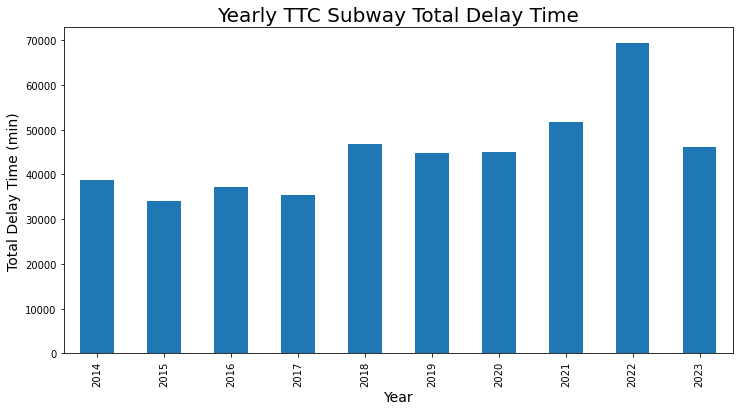

In [27]:
# Total delay counts by year
yearly_delay_time = real_delay.groupby(real_delay.index.year)["Min Delay"].sum()
yearly_delay_time.plot(kind = "bar", figsize = (12, 6))
plt.title("Yearly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)

plt.show()

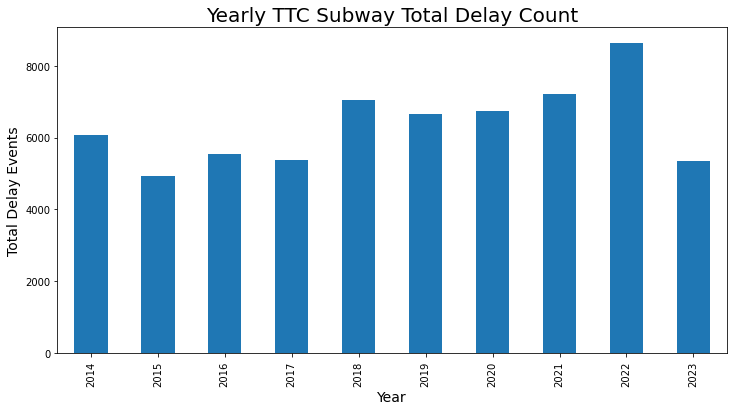

In [28]:
# Total number of delay by year
yearly_delay_count = real_delay.groupby(real_delay.index.year)["Min Delay"].count()
yearly_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Yearly TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

Need to change the ticks to name (e.g. Jan, Feb...)

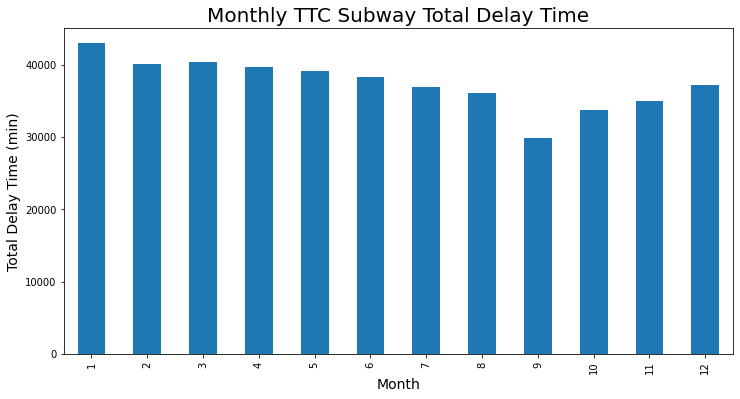

In [29]:
# Total delay time by months
monthly_delay_time = real_delay.groupby(real_delay.index.month)["Min Delay"].sum()
monthly_delay_time.plot(kind = "bar", figsize = (12, 6))
plt.title("Monthly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)


plt.show()

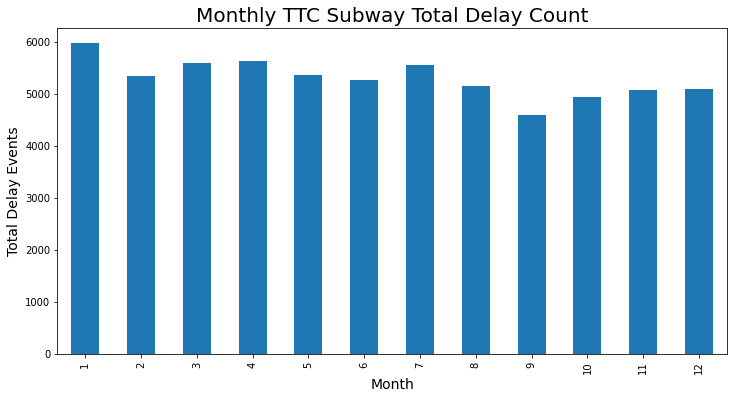

In [30]:
## Total number of delay by months
monthly_delay_count = real_delay.groupby(real_delay.index.month)["Min Delay"].count()
monthly_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Monthly TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

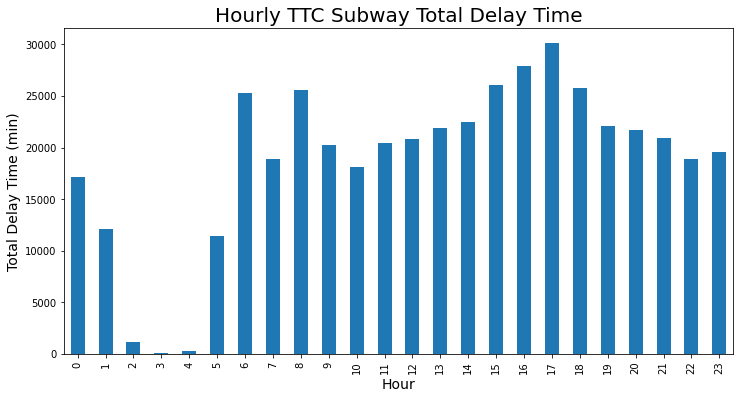

In [31]:
# Total delay time by hours
hourly_delay_time = real_delay.groupby(real_delay.index.hour)["Min Delay"].sum()
hourly_delay_time.plot(kind = "bar", figsize = (12, 6))
plt.title("Hourly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Hour", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)


plt.show()

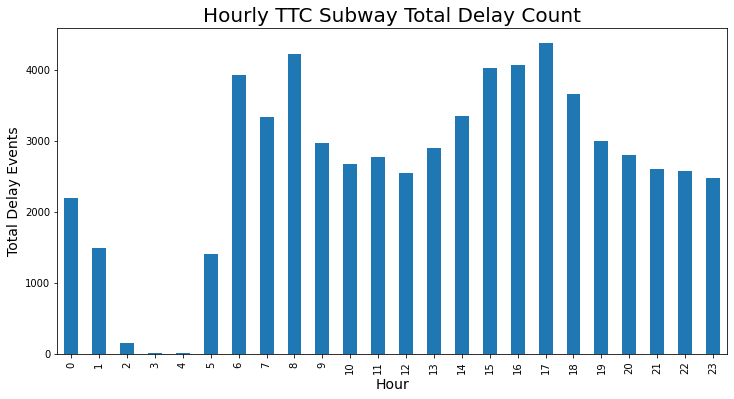

In [32]:
## Total number of delay by hours
hourly_delay_count = real_delay.groupby(real_delay.index.hour)["Min Delay"].count()
hourly_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Hourly TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Hour", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

In [33]:
# ## Create a columns for period.
# ## Set five periods for a day
# ## Period#1 (0-6): early morning - off-rush-hour
# ## Period#2 (6-9): daytime - morning rush hour, Period#3 (9-16): daytime - off-rush-hour
# ## Period#4 (16-20): night - night rush hour, Period#5 (20 - 24): nighttime - off-rush-hour

# bins = [0, 6, 9, 16, 20, 24]
# labels = [1, 2, 3, 4, 5]
# real_delay.loc[:, 'Period'] = np.digitize(real_delay.index.hour, bins, right=False)
# real_delay.loc[:, 'Period'] = real_delay.loc[:,'Period'].map(dict(zip(range(1, len(labels)+1), labels)))

# real_delay.head()

In [34]:
# ## Total delay time by periods
# real_delay.groupby("Period")["Min Delay"].sum().sort_values(ascending=False)

In [35]:
# ## Total delay time by periods

# real_delay.groupby("Period")["Min Delay"].count().sort_values(ascending=False)

5. Top five reasons for short time and long time delays

The short-term delay is determined if the min delay time. 

1). Short term delay if the min gap is within 5 mintes, 

2). Medium term delay if the min delay is 5 < min delay < 10,

3). Long term delay if the min delay is > 10 mins

*TTC might be suggested to take different actions based on different delay type

In [36]:
# ## Defind the delay type based on the min delay time and add a column for delay type 

# def delay_type(gap):
#     if gap >= 1 and gap < 5:
#         return 'short-term delay'
#     elif gap >= 5 and gap <= 10:
#         return 'medium-term delay'
#     elif gap >= 10:
#         return 'long-term delay'
    
# real_delay.loc[:, 'delay_type'] = real_delay['Min Delay'].apply(delay_type)

# real_delay.head()

In [37]:
# Top delay reasons less than 10 minutes
short_delay_reason = real_delay[real_delay["Min Delay"] <= 10]["Code description"].value_counts()
short_delay_reason.head(5)

Disorderly Patron                                           5941
Injured or ill Customer (On Train) - Medical Aid Refused    3352
Passenger Assistance Alarm Activated - No Trouble Found     3183
Door Problems - Faulty Equipment                            2529
ATC Project                                                 2083
Name: Code description, dtype: int64

In [38]:
short_delay_reason_time = real_delay[real_delay["Min Delay"] <= 10].groupby("Code description")["Min Delay"].sum().sort_values(ascending = False)
short_delay_reason_time.head(5)

Code description
Disorderly Patron                                           28477
Injured or ill Customer (On Train) - Medical Aid Refused    15777
Door Problems - Faulty Equipment                            12478
Passenger Assistance Alarm Activated - No Trouble Found     11716
Injured or ill Customer (On Train) - Transported            11137
Name: Min Delay, dtype: int64

In [39]:
top_short_delay_reasons = list(set(list(short_delay_reason[0:5].index) + list(short_delay_reason_time[0:5].index)))
top_short_delay_reasons

['Door Problems - Faulty Equipment',
 'Injured or ill Customer (On Train) - Transported',
 'Passenger Assistance Alarm Activated - No Trouble Found',
 'Injured or ill Customer (On Train) - Medical Aid Refused',
 'Disorderly Patron',
 'ATC Project']

In [40]:
top_short_delay_time = real_delay[real_delay["Code description"].isin(top_short_delay_reasons)]
top_short_delay_time

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00
2018-01-01 08:41:00,Monday,VICTORIA PARK STATION,EUDO,6,10,W,BD,5030,Door Problems - Faulty Equipment,08:00 - 09:00
2018-01-01 15:36:00,Monday,SHERBOURNE STATION,SUDP,5,10,E,BD,5269,Disorderly Patron,15:00 - 16:00
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 14:57:00,Sunday,EGLINTON STATION,SUDP,3,7,N,YUS,5931,Disorderly Patron,14:00 - 15:00
2017-12-31 20:46:00,Sunday,DAVISVILLE STATION,SUDP,9,14,N,YUS,5446,Disorderly Patron,20:00 - 21:00
2017-12-31 21:52:00,Sunday,YORK MILLS STATION,SUDP,3,8,N,YUS,5851,Disorderly Patron,21:00 - 22:00


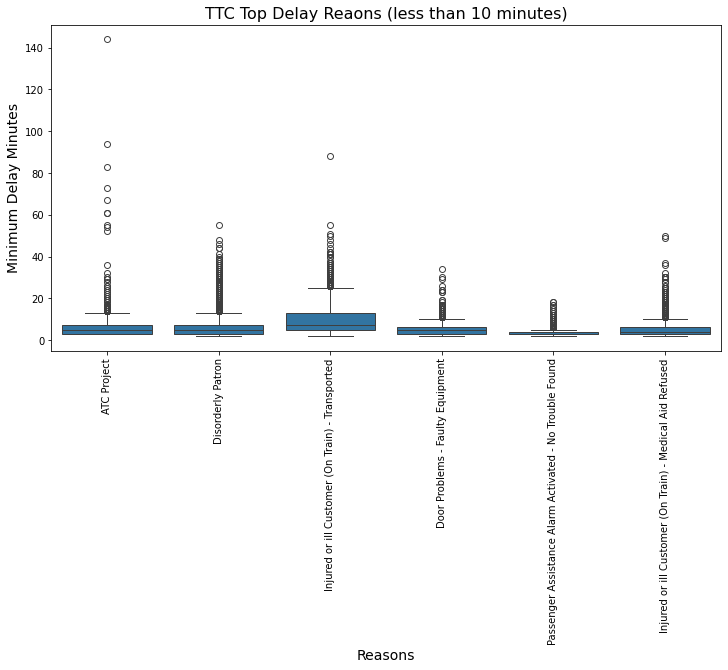

In [41]:
plt.figure(figsize = (12, 6))
sns.boxplot(x=top_short_delay_time["Code description"], y=top_short_delay_time["Min Delay"])
plt.title("TTC Top Delay Reaons (less than 10 minutes)", fontsize = 16)
plt.xlabel("Reasons", fontsize = 14)
plt.ylabel("Minimum Delay Minutes", fontsize = 14)
plt.xticks(rotation = 90)
plt.show()

In [42]:
# Top delay reasons more than 10 minutes
long_delay_reason = real_delay[real_delay["Min Delay"] > 10]["Code description"].value_counts()
long_delay_reason.head(5)

Injured or ill Customer (On Train) - Transported    974
Unauthorized at Track Level                         854
Disorderly Patron                                   813
Fire/Smoke Plan B - Source TTC                      633
Passenger Other                                     482
Name: Code description, dtype: int64

In [43]:
long_delay_reason_time = real_delay[real_delay["Min Delay"] > 10].groupby("Code description")["Min Delay"].sum().sort_values(ascending = False)
long_delay_reason_time.head(5)

Code description
Priority One - Train in Contact With Person         24548
Unauthorized at Track Level                         18341
Fire/Smoke Plan B - Source TTC                      17357
Injured or ill Customer (On Train) - Transported    16617
Disorderly Patron                                   13363
Name: Min Delay, dtype: int64

In [44]:
top_long_delay_reasons = list(set(list(long_delay_reason[0:5].index) + list(long_delay_reason_time[0:5].index)))
top_long_delay_reasons

['Unauthorized at Track Level',
 'Injured or ill Customer (On Train) - Transported',
 'Passenger Other',
 'Disorderly Patron',
 'Fire/Smoke Plan B - Source TTC',
 'Priority One - Train in Contact With Person']

In [45]:
top_long_delay_time = real_delay[real_delay["Code description"].isin(top_long_delay_reasons)]
top_long_delay_time

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00
2018-01-01 11:46:00,Monday,KENNEDY BD STATION,SUUT,4,8,W,BD,5046,Unauthorized at Track Level,11:00 - 12:00
2018-01-01 15:36:00,Monday,SHERBOURNE STATION,SUDP,5,10,E,BD,5269,Disorderly Patron,15:00 - 16:00
2018-01-01 16:47:00,Monday,VICTORIA PARK STATION,MUPR1,62,67,W,BD,5225,Priority One - Train in Contact With Person,16:00 - 17:00
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 20:46:00,Sunday,DAVISVILLE STATION,SUDP,9,14,N,YUS,5446,Disorderly Patron,20:00 - 21:00
2017-12-31 21:33:00,Sunday,QUEEN STATION,SUUT,5,9,N,YUS,5736,Unauthorized at Track Level,21:00 - 22:00
2017-12-31 21:52:00,Sunday,YORK MILLS STATION,SUDP,3,8,N,YUS,5851,Disorderly Patron,21:00 - 22:00


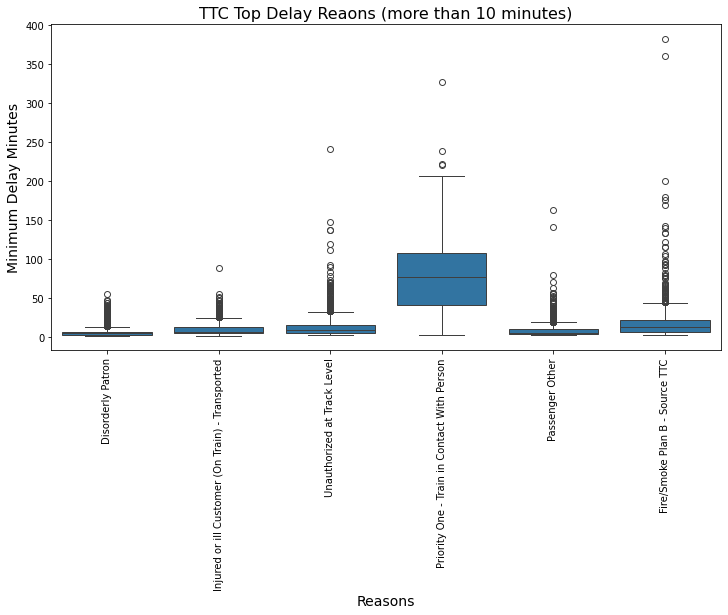

In [46]:
plt.figure(figsize = (12, 6))
sns.boxplot(x=top_long_delay_time["Code description"], y=top_long_delay_time["Min Delay"])
plt.title("TTC Top Delay Reaons (more than 10 minutes)", fontsize = 16)
plt.xlabel("Reasons", fontsize = 14)
plt.ylabel("Minimum Delay Minutes", fontsize = 14)
plt.xticks(rotation = 90)
plt.show()

6. Mechanical Issues

Codes start with "E" or "P" are mechanical or signal issues from TTC.

In [47]:
TTC_delay_code_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Code              200 non-null    object
 1   Code description  200 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


In [48]:
mech_code = [TTC_delay_code_name["Code"][i] for i in range(len(TTC_delay_code_name["Code"])) if isinstance(TTC_delay_code_name["Code"][i], str) and (TTC_delay_code_name["Code"][i].startswith("E") or TTC_delay_code_name["Code"][i].startswith("P"))]
print(mech_code)


['EUAC', 'EUAL', 'EUATC', 'EUBK', 'EUBO', 'EUCA', 'EUCD', 'EUCH', 'EUCO', 'EUDO', 'EUECD', 'EUHV', 'EULT', 'EULV', 'EUME', 'EUNEA', 'EUNT', 'EUO', 'EUOE', 'EUOPO', 'EUPI', 'EUSC', 'EUTL', 'EUTM', 'EUTR', 'EUTRD', 'EUVA', 'EUVE', 'EUYRD', 'PUATC', 'PUCBI', 'PUCSC', 'PUCSS', 'PUDCS', 'PUMEL', 'PUMO', 'PUMST', 'PUOPO', 'PUSAC', 'PUSBE', 'PUSCA', 'PUSCR', 'PUSEA', 'PUSI', 'PUSIO', 'PUSIS', 'PUSLC', 'PUSNT', 'PUSO', 'PUSRA', 'PUSSW', 'PUSTC', 'PUSTP', 'PUSTS', 'PUSWZ', 'PUSZC', 'PUTCD', 'PUTD', 'PUTDN ', 'PUTIJ', 'PUTIS', 'PUTNT', 'PUTO', 'PUTOE', 'PUTR', 'PUTS', 'PUTSC', 'PUTSM', 'PUTTC', 'PUTTP', 'PUTWZ', 'ERAC', 'ERBO', 'ERCD', 'ERCO', 'ERDB', 'ERDO', 'ERHV', 'ERLT', 'ERLV', 'ERME', 'ERNEA', 'ERNT', 'ERO', 'ERPR', 'ERRA', 'ERTB', 'ERTC', 'ERTL', 'ERTR', 'ERVE', 'ERWA', 'ERWS', 'PREL', 'PRO', 'PRS', 'PRSA', 'PRSL', 'PRSO', 'PRSP', 'PRST', 'PRSW', 'PRTST', 'PRW']


In [49]:
# Most common mechanical issues
mech_issues = real_delay[real_delay["Code"].isin(mech_code)].groupby("Code")["Min Delay"].count().sort_values(ascending = False)
mech_issues.head(10)

Code
EUDO     2128
PUOPO    1549
EUNT      994
EUBK      874
PUSTS     571
ERDO      521
ERTC      503
EUBO      492
EUPI      385
PUSTC     352
Name: Min Delay, dtype: int64

In [50]:
# Total number of mechanical issues over ten years
mech_issues.values.sum()

15394

In [51]:
train = pd.DataFrame(real_delay[(real_delay["Code"].isin(mech_code)) & (real_delay["Vehicle"] != 0)].groupby(["Vehicle", "Line"])["Code"].value_counts())
train.head(40)

Code
Vehicle Line Code       
2       SRT  ERDO      1
3       SRT  ERPR      1
5       BD   EUAC      1
             EUDO      1
             EUYRD     1
        YUS  EUNT      1
6       SRT  ERPR      1
71      YUS  EUVE      1
361     SRT  PRO       1
364     SRT  ERTC      2
368     SRT  ERTC      1
1076    BD   EUDO      1
2023    SRT  ERDB      1
2066    BD   EUME      1
2574    BD   EUNT      1
3000    SRT  ERTC     22
             ERDO     15
             ERNEA    10
             ERPR      5
             ERCD      4
             PRO       4
             PRSA      4
             ERCO      3
             ERLV      3
             ERWA      3
             ERME      2
             ERTL      2
             ERTR      2
             PRS       2
             PRSL      2
             ERAC      1
             ERDB      1
             ERLT      1
             ERNT      1
             ERRA      1
3001    SRT  ERTC     24
             ERDO     20
             ERPR      9
             ERAC      4
             ERNT      3

In [52]:
YUS_train = pd.DataFrame(real_delay[(real_delay["Code"].isin(mech_code)) & (real_delay["Line"] == "YUS") & (real_delay["Vehicle"] != 0)])
YUS_train.shape


(6335, 10)

In [53]:
BD_train = pd.DataFrame(real_delay[(real_delay["Code"].isin(mech_code)) & (real_delay["Line"] == "BD") & (real_delay["Vehicle"] != 0)])
BD_train.shape


(5916, 10)

In [54]:
SRT_train = pd.DataFrame(real_delay[(real_delay["Code"].isin(mech_code)) & (real_delay["Line"] == "SRT") & (real_delay["Vehicle"] != 0)])
SRT_train.shape


(2034, 10)

In [55]:
SHP_train = pd.DataFrame(real_delay[(real_delay["Code"].isin(mech_code)) & (real_delay["Line"] == "SHP") & (real_delay["Vehicle"] != 0)])
SHP_train.shape


(801, 10)

In [56]:
YUS_train_code = YUS_train.groupby(['Vehicle', 'Code'])
YUS_train_code

7. Top Delay Reason for each station

In [57]:
## The count here shows number 
TTC_delay_stations_count = real_delay.groupby(["Station"]).agg(total_count=('Code', 'count'), max_delay_code=('Code', 'max')).sort_values(by='total_count', ascending=False)
TTC_delay_stations_count.head(60)

,total_count,max_delay_code
Station,,
FINCH STATION,2762,TUSUP
KENNEDY BD STATION,2742,TUSUP
VAUGHAN MC STATION,2387,TUSUP
EGLINTON STATION,2320,TUSUP
KIPLING STATION,2281,TUSUP
WILSON STATION,1855,TUSUP
SHEPPARD WEST STATION,1853,TUSUP
BLOOR STATION,1583,TUSC
MCCOWAN STATION,1551,TRTC
